In [8]:
import math
import numpy as np
import tensorflow as tf

from keras import *
from keras import backend as K
from matplotlib import pyplot as plt
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import activations, initializers, regularizers, constraints, Lambda

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3))
test_images = test_images.reshape((10000, 32, 32, 3))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# train_images, test_images = train_images - 0.5, test_images - 0.5
# train_images, test_images = train_images * 2, test_images * 2

# To one-hot
train_labels = utils.to_categorical(train_labels, 10)
test_labels = utils.to_categorical(test_labels, 10)

In [67]:
model = models.Sequential()

model.add(layers.Convolution2D(32, 3, padding='same',
                               input_shape=(32, 32, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Convolution2D(32, 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Convolution2D(64, 3, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Convolution2D(64, 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.5))
# model.add(AMSoftmax(10, 10, 0.35))
model.add(layers.Dense(10))

In [62]:
model.predict(train_images[:2]).shape

(2, 10)

In [33]:
base = applications.ResNet50(include_top=False, input_shape=(32, 32, 3), pooling='avg')
for layer in base.layers[:-5]:
    layer.trainable=False
x = layers.Dense(10)(base.output)
model = Model(base.input, x)

In [49]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_softmax = model.fit(train_images, train_labels, epochs=5,
                            validation_data=(test_images, test_labels));

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 17s 344us/step - loss: 1.4474 - acc: 0.4737 - val_loss: 1.0953 - val_acc: 0.6035
Epoch 2/5
50000/50000 [==============================] - 11s 222us/step - loss: 1.0316 - acc: 0.6345 - val_loss: 0.8945 - val_acc: 0.6794
Epoch 3/5
50000/50000 [==============================] - 11s 224us/step - loss: 0.8494 - acc: 0.6998 - val_loss: 0.7533 - val_acc: 0.7348
Epoch 4/5
50000/50000 [==============================] - 11s 211us/step - loss: 0.7400 - acc: 0.7388 - val_loss: 0.7285 - val_acc: 0.7445
Epoch 5/5
50000/50000 [==============================] - 11s 218us/step - loss: 0.6601 - acc: 0.7676 - val_loss: 0.7340 - val_acc: 0.7486


In [68]:
import math

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lrate = callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate]

model.compile(optimizer='adam',
              loss=softmax_loss(t=1., s=1),
              metrics=['accuracy'])

history_softmax = model.fit(train_images, train_labels, epochs=5,
                            validation_data=(test_images, test_labels));

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 20s 406us/step - loss: 0.1441 - acc: 0.4740 - val_loss: 0.1174 - val_acc: 0.5789
Epoch 2/5
50000/50000 [==============================] - 12s 234us/step - loss: 0.1048 - acc: 0.6279 - val_loss: 0.0927 - val_acc: 0.6683
Epoch 3/5
50000/50000 [==============================] - 11s 227us/step - loss: 0.0885 - acc: 0.6887 - val_loss: 0.0822 - val_acc: 0.7136
Epoch 4/5
50000/50000 [==============================] - 12s 231us/step - loss: 0.0775 - acc: 0.7272 - val_loss: 0.0767 - val_acc: 0.7365
Epoch 5/5
50000/50000 [==============================] - 11s 221us/step - loss: 0.0678 - acc: 0.7621 - val_loss: 0.0749 - val_acc: 0.7434


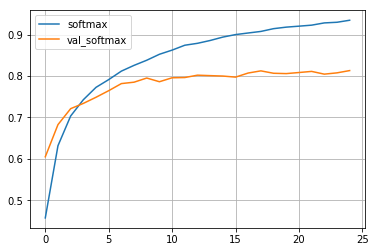

In [40]:
# with norm and s=32
plt.plot(history_softmax.history['acc'], label='softmax')
plt.plot(history_softmax.history['val_acc'], label='val_softmax')
plt.legend()
plt.grid();

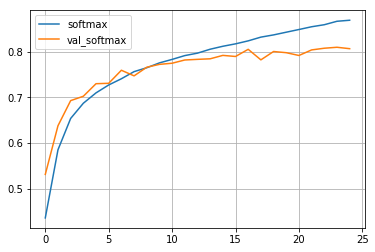

In [43]:
# with norm and s=32
plt.plot(history_softmax.history['acc'], label='softmax')
plt.plot(history_softmax.history['val_acc'], label='val_softmax')
plt.legend()
plt.grid();

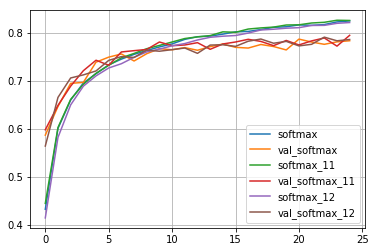

In [25]:
plt.plot(history_softmax.history['acc'], label='softmax')
plt.plot(history_softmax.history['val_acc'], label='val_softmax')
plt.plot(history_softmax_105.history['acc'], label='softmax_11')
plt.plot(history_softmax_105.history['val_acc'], label='val_softmax_11')
plt.plot(history_softmax_12.history['acc'], label='softmax_12')
plt.plot(history_softmax_12.history['val_acc'], label='val_softmax_12')
plt.legend()
plt.grid();

---

In [63]:
from tensorflow.python.ops import array_ops


def softmax_loss(t=1.0, s=1, m=0.35):

    t = float(t)
    s = float(s)
    m = float(m)
    
    def softmax_loss_fixed(y_true, logits):
        """Softmax loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is raw logits
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        zeros = array_ops.zeros_like(logits, dtype=logits.dtype)
        ones = array_ops.ones_like(logits, dtype=logits.dtype)
        
        # Возможно косяк здесь! Хз как правильно искать значение логита на тру-классе
        logit_y = tf.reduce_sum(tf.multiply(y_true, logits), axis=-1, keepdims=True) - m
        I_k = array_ops.where(logit_y >= logits, zeros, ones)
        
        h = tf.exp(s*tf.multiply(t - 1., tf.multiply(logits + 1., I_k)))
        
        # softmax = tf.exp(logits) / tf.reduce_sum(tf.multiply(tf.exp(logits), h))
#         softmax = tf.exp(logits) / (tf.reshape(
#             tf.reduce_sum(tf.multiply(tf.exp(logits), h), axis=-1, keepdims=True), 
#             [-1, 1]))
        softmax = tf.exp(s*logits) / (tf.reduce_sum(tf.multiply(tf.exp(s*logits), h), 
                                                    axis=-1, keepdims=True) + epsilon)
        # softmax = tf.nn.softmax(logits)
        # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits))
        
        # We add epsilon because log(0) = nan
        softmax = tf.add(softmax, epsilon)
        ce = tf.multiply(y_true, -tf.log(softmax))
        return tf.reduce_mean(ce)
    
    return softmax_loss_fixed

In [53]:
class AMSoftmax(Layer):
    def __init__(self, units, s, m,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 kernel_constraint=None,
                 **kwargs
                 ):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(AMSoftmax, self).__init__(**kwargs)
        self.units = units
        self.s = s
        self.m = m
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True


    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.bias = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True


    def call(self, inputs, **kwargs):
#         inputs = tf.nn.l2_normalize(inputs, dim=-1)
#         self.kernel = tf.nn.l2_normalize(self.kernel, dim=(0, 1))   # W归一化
        inputs = tf.nn.l2_normalize(inputs, dim=0)
        self.kernel = tf.nn.l2_normalize(self.kernel, dim=1)   # W归一化
        dis_cosin = K.dot(inputs, self.kernel)
        # psi = dis_cosin - self.m

        # e_costheta = K.exp(self.s * dis_cosin)
        # e_psi = K.exp(self.s * psi)
        # sum_x = K.sum(e_costheta, axis=-1, keepdims=True)

        # temp = e_psi - e_costheta
        # temp = temp + sum_x

        # output = e_psi / temp
        return dis_cosin


def amsoftmax_loss(y_true, y_pred):
    d1 = K.sum(y_true * y_pred, axis=-1)
    d1 = K.log(K.clip(d1, K.epsilon(), None))
    loss = -K.mean(d1, axis=-1)
    return loss